Importing the stuff we need

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import nltk

2023-12-05 09:34:26.590472: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 09:34:26.590552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 09:34:26.590597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 09:34:26.597468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/sgzmd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defining some constants

In [3]:
# Constants
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 128

Let's read and pre-process the data

In [4]:
df = pd.read_csv("../full.csv")  # Load the CSV file into a pandas DataFrame

# drop all non-string records, unclear where they are coming from
df = df[df.apply(lambda row: isinstance(row['Body'], str) and isinstance(row['Genres'], str), axis=1)]

def is_sf_genre(genre: str) -> bool:
    return genre.startswith('sf') or genre == 'popadanec' or genre == 'litrpg'

# define is_sf label
df['is_sf'] = df['Genres'].apply(lambda genres: any(is_sf_genre(genre) for genre in genres.split(';')))
df.head()

,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf
0,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_fantasy_city;det_action;popadanec;magician_...,Извращенный отшельник;Илья Романов,Наемник «S» ранга,sf_fantasy_city\n det_action\n popadanec\n...,"\n Прожив пять веков в шкуре вампира, я оты...",729588.fb2,0,True
1,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,fanfiction;magician_book;popadanec;network_lit...,Cyberdawn,Лишний свиток,fanfiction\n magician_book\n popadanec\n ...,"\n Попаданец в черножопого, ехидного, своло...",729587.fb2,0,True
2,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,religion_orthodoxy;religion_christianity;relig...,Коллектив авторов,Святитель Василий Великий,religion_orthodoxy\n religion_christianity\n...,NaN,729595.fb2,0,False
3,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_heroic;sf_humor;sf_social,Андрей Немиров,Квестер,sf_heroic\n sf_humor\n sf_social\n \n ...,"\n Доброго времени суток, читатель! По слов...",729601.fb2,0,True
4,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_horror;literature_19;literature_20;sf_horro...,Джеймс Брандер Мэтьюз;Артур Грей;Эдмунд Митчел...,Мистические истории. Фантом озера,sf_horrorliterature_19literature_20sf_horrorfo...,NaN,729599.fb2,0,True


Let's define synthetic column that we'll be doing the actual classification on

In [5]:
# remove all rows which do not have annotation
df = df[df['Annotation'].str.len() >= 20]

# Create 'body' field by concatenating 'Annotation', 'Authors', 'Genres', and 'BookTitle'
df['body'] = df['Annotation'] + ' ' + df['Authors'] + ' ' + df['Genres'] + ' ' + df['BookTitle']
df.sample(10)

,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf,body
168548,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_contemporary,Маргарита Дюжева,Я тебя верну,love_contemporary\n \n Маргарита\n Дюж...,"\n Возвращаясь домой, я думала, что все ост...",674881.fb2,0,False,"\n Возвращаясь домой, я думала, что все ост..."
43941,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,home_cooking;home_health,Татьяна Рыжова,Диабет. Есть – чтобы жить,home_cooking\n home_health\n \n Татьяна...,"\n Больные сахарным диабетом знают, что это...",312639.fb2,0,False,"\n Больные сахарным диабетом знают, что это..."
146894,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_action;sf_heroic,Серж Винтеркей,Рубеж 4: В игре,sf_action sf_heroic Серж Винтеркей 5176dada-c...,Приключения героев серии бестселлеров «Рубеж» ...,621419.fb2,0,True,Приключения героев серии бестселлеров «Рубеж» ...
181328,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,popadancy;sf_action;adventure,Макс Вальтер,Смерть может танцевать 6,popadancy\n sf_action\n adventure\n \n ...,"\n Неизвестный новый мир, который предстоит...",708769.fb2,0,True,"\n Неизвестный новый мир, который предстоит..."
138268,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,foreign_sf;sf_social;sf,Станислав Лем,Охота,foreign_sfsf_socialsf СтаниславГерманЛем2c204a...,"В этом сборнике Станислав Лем, виртуоз нестанд...",598207.fb2,0,True,"В этом сборнике Станислав Лем, виртуоз нестанд..."
169240,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_litrpg;sf_postapocalyptic,Андрей Ефремов,Симбиоз-1. Алый шторм,sf_litrpg\n sf_postapocalyptic\n \n Анд...,"\n Сколько требуется времени, чтобы привычн...",676619.fb2,0,True,"\n Сколько требуется времени, чтобы привычн..."
220648,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,prose_contemporary,Джон Хоукс,Лягух,prose_contemporary Джон Хоукс Лягух Незауряд...,"Незауряден тот, кто приютил лягушку! Да-да, у ...",78803.fb2,0,False,"Незауряден тот, кто приютил лягушку! Да-да, у ..."
184058,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf;sf_horror,Алексей Зазнайкин,Вы верите в демонов?,sfsf_horrorАлексейЗазнайкинd00dbf32-3edf-4ca5-...,Вы верите в демонов? А верите ли вы в ангелов?...,715561.fb2,0,True,Вы верите в демонов? А верите ли вы в ангелов?...
108720,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,unrecognised;sf_fantasy;unrecognised,,Я Апокалипсис - Приятно Познакомиться. Том 1 (СИ),unrecognised\n sf_fantasy\n unrecogn...,"\n \tОбычный день, 10 июля 2016 года. Л...",520690.fb2,0,True,"\n \tОбычный день, 10 июля 2016 года. Л..."
30817,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_history,Виктор Побережных,Три дня и вся жизнь,sf_history\n\nВиктор\nПобережных\n\nТри дня и ...,\nПравленая версия рассказа. Убраны нестыковки...,256596.fb2,0,True,\nПравленая версия рассказа. Убраны нестыковки...


In [6]:
# Filter the dataframe based on the conditions
df_selected_1 = df[(df['IsSelected'] == 1)]
df_selected_0 = df[(df['IsSelected'] == 0) & (~df['is_sf'])]

# -1 are manually selected negative samples
df_selected_neg = df[(df['IsSelected'] == -1)]

# Sample the same number of records where selected = 0
df_selected_0_sampled = df_selected_0.sample(n=len(df_selected_1), random_state=42)

negative_samples = pd.concat([df_selected_0_sampled, df_selected_neg])

# Set 'selected' to 0 for all negative_samples
negative_samples['IsSelected'] = 0

# Concatenate the two dataframes
new_df = pd.concat([df_selected_1, negative_samples])

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

# Print the new dataframe
new_df.sample(10)


,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf,body
908,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_contemporary,Маша Драч,Запретный плод,love_contemporary\n \n Маша\n Драч\n ...,"\n Можно ли быть вместе, если существуют за...",618555.fb2,0,False,"\n Можно ли быть вместе, если существуют за..."
1129,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,det_action;love_erotica,Натали Бранде,Голубые шинели,det_action\n love_erotica\n \n Натали\n...,\n Он прошел долгий и кровавый путь от прос...,226205.fb2,0,False,\n Он прошел долгий и кровавый путь от прос...
164,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,fantasy_fight;popadanec,Константин Муравьёв,Мастер лута,fantasy_fightpopadanec КонстантинНиколаевичМур...,"Если ты сумел выжить в лесу, который до этого ...",438417.fb2,1,True,"Если ты сумел выжить в лесу, который до этого ..."
91,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_fantasy,Александр Сапегин,Жестокая сказка,sf_fantasy\n \n Александр\n Павлович\n...,\n Магические миры совсем не похожи на добр...,258090.fb2,1,True,\n Магические миры совсем не похожи на добр...
1299,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,child_prose;child_sf,Наталья Дубина,Инсталляция,child_prose\n child_sf\n \n Наталья\n ...,\n Сборник коротких рассказов с фантастичес...,348196.fb2,0,False,\n Сборник коротких рассказов с фантастичес...
987,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,periodic,Мэрилин Мерлин,Дом любви и печали,periodic\n \n Мэрилин\n Мерлин\n ...,\n Постепенно расплывчатое пятно начало п...,550692.fb2,0,False,\n Постепенно расплывчатое пятно начало п...
136,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,popadanec;sf_action,Роман Глушков,Побег,popadanecsf_action\n РоманАнатольевичГлушков...,\n «Рифт-75» — тюрьма для самых отпетых вое...,367428.fb2,1,True,\n «Рифт-75» — тюрьма для самых отпетых вое...
58,/pool1/share/Downloads/Flibusta-Patch/f.fb2-74...,unrecognised;popadanec;sf_fantasy,Антон Панарин,Не грози Дубровскому! Том II (СИ),unrecognised\n popadanec\n sf_fantas...,\n \t\tПока строится фармацевтическая и...,749590.fb2,1,True,\n \t\tПока строится фармацевтическая и...
589,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,network_literature;popadancy,Андрей Кощиенко,Файтин!,network_literature\n popadancy\n \n ...,"\n Многие думают, что ""Файтин"" — это коре...",693346.fb2,1,False,"\n Многие думают, что ""Файтин"" — это коре..."
62,/pool1/share/Downloads/Flibusta-Patch/f.fb2-74...,sf_history;popadanec;magician_book;sf_fantasy_...,Валерий Пылаев,Гимназия №6,sf_history\n popadanec\n magician_book\n ...,"\n Герой, воитель, спаситель, защитник обез...",750284.fb2,1,True,"\n Герой, воитель, спаситель, защитник обез..."


Defining tokenizer and some helper methods

In [7]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Function to segment and tokenize text
def segment_and_tokenize(text):
    # Split text into sentences
    sentences = sent_tokenize(text, language='russian')
    tokenized_output = []
    attention_mask_output = []

    for sentence in sentences:
        # Tokenize each sentence
        tokens = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_TOKENS, 
                                       truncation=True, padding='max_length', return_tensors='tf')
        tokenized_output.append(tokens['input_ids'])
        attention_mask_output.append(tokens['attention_mask'])

        # Check if we've reached the maximum number of tokens
        if sum([len(t[0]) for t in tokenized_output]) >= MAX_TOKENS:
            break

    # Combine tokenized sentences up to the maximum length
    input_ids = tf.concat(tokenized_output, axis=1)[0,:MAX_TOKENS]
    attention_mask = tf.concat(attention_mask_output, axis=1)[0,:MAX_TOKENS]

    return input_ids, attention_mask

Let's run the tokenization and segmentation of the data

In [8]:
# Apply the function to the dataset
new_df['segmented_data'] = new_df['body'].apply(segment_and_tokenize)
new_df[['tokens', 'attention_mask']] = pd.DataFrame(new_df['segmented_data'].tolist(), index=new_df.index)

2023-12-05 09:34:55.721195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 09:34:55.725214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 09:34:55.725244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 09:34:55.726810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 09:34:55.726842: I tensorflow/compile

Now let's prepare and split the dataset

In [9]:
# Prepare dataset
X_ids = np.array(new_df['tokens'].tolist())
X_mask = np.array(new_df['attention_mask'].tolist())

y = new_df['is_sf'].values
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(X_ids, X_mask, y.astype('int32'), test_size=0.2)


Let's load the model now and define how we are fine-tuning it

In [10]:
bert = TFAutoModel.from_pretrained(MODEL_NAME, from_pt=True)
input_ids = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='attention_mask')

embeddings = bert(input_ids, attention_mask=input_mask)[0]
pooled = GlobalMaxPool1D()(embeddings)
output = Dense(1, activation='sigmoid')(pooled)

model = Model(inputs=[input_ids, input_mask], outputs=output)

2023-12-05 09:34:58.480805: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a 

In [11]:
model.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:

history = model.fit([X_train_ids, X_train_mask], y_train, batch_size=16, epochs=2, validation_split=0.2)

Epoch 1/2


2023-12-05 09:35:15.289071: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7facd01da260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 09:35:15.289097: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-12-05 09:35:15.292263: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 09:35:15.386494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-05 09:35:15.423164: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58/58 [==============================] - 40s 347ms/step - loss: 0.5695 - accuracy: 0.6948 - val_loss: 0.4100 - val_accuracy: 0.7931
Epoch 2/2
58/58 [==============================] - 19s 322ms/step - loss: 0.2662 - accuracy: 0.8950 - val_loss: 0.3710 - val_accuracy: 0.8405


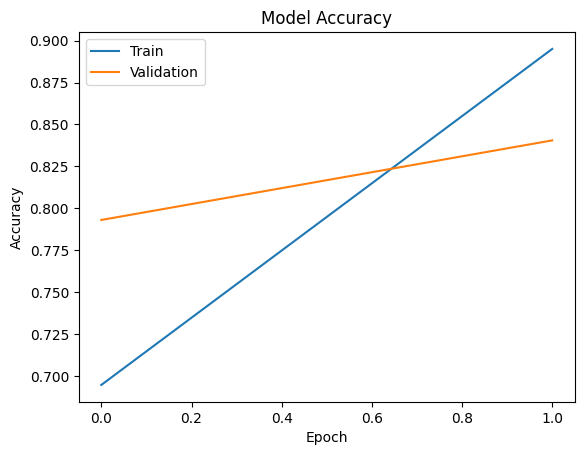

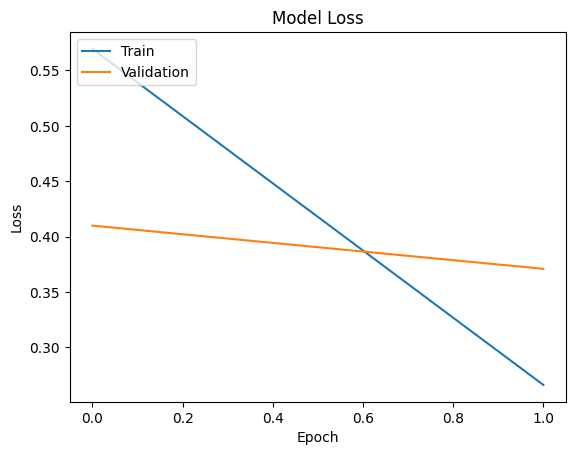

In [13]:
import matplotlib.pyplot as plt

# 'history' is the object returned by the model.fit() method in TensorFlow

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
model.evaluate([X_test_ids, X_test_mask], y_test)

10/10 [==============================] - 2s 170ms/step - loss: 0.3588 - accuracy: 0.8304


[0.3587760031223297, 0.8304498195648193]

Let's take a quick look at false positives

In [15]:
predictions = model.predict([X_test_ids, X_test_mask])
predicted_labels = (predictions > 0.5).astype('int32')
false_positives = np.where((predicted_labels == 1) & (y_test == 0))[0]

for index in false_positives[:10]:  # Top 10 false positives
    print(f"Index: {index}, Prediction: {predictions[index]}, Actual: {y_test[index]}")

10/10 [==============================] - 3s 167ms/step
Index: 1, Prediction: [0.9787138], Actual: 1
Index: 1, Prediction: [0.9787138], Actual: 1
Index: 1, Prediction: [0.9787138], Actual: 1
Index: 1, Prediction: [0.9787138], Actual: 1
Index: 1, Prediction: [0.9787138], Actual: 1
Index: 1, Prediction: [0.9787138], Actual: 1
Index: 1, Prediction: [0.9787138], Actual: 1
Index: 1, Prediction: [0.9787138], Actual: 1
Index: 1, Prediction: [0.9787138], Actual: 1
Index: 1, Prediction: [0.9787138], Actual: 1


In [16]:
model.save('mode-annotation-genre-author-title.h5')

/home/sgzmd/code/FliNet/toy/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# import tensorflow
# from tensorflow.keras.models import load_model
# # print(load_model)

# model = tensorflow.keras.models.load_model('mode-annotation-genre-author-title.keras')


In [18]:
df_sf = df[(df['IsSelected'] == 0) & df['is_sf']]
df_sf = df_sf.dropna(subset=['body'])

df_sf['segmented_data'] = df_sf['body'].apply(segment_and_tokenize)
df_sf[['tokens', 'attention_mask']] = pd.DataFrame(df_sf['segmented_data'].tolist(), index=df_sf.index)

inference_X_ids = np.array(df_sf['tokens'].tolist())
inference_X_mask = np.array(df_sf['attention_mask'].tolist())


# Make predictions
predictions = model.predict([inference_X_ids, inference_X_mask])

# Get the top 100 results
top_1000_results = df_sf.iloc[predictions.argsort(axis=0)[-1000:].flatten()]


3588/3588 [==============================] - 1179s 329ms/step


In [19]:
top_1000_results.to_csv('top_1000_results.csv', index=True)

In [25]:
top_1000_results['FileName'].to_csv('top_1000_small_matched.txt', index=False, header=False)
SQL = """
DROP TABLE IF EXISTS DetectedBooks;

CREATE TABLE DetectedBooks (
    BookId INT NOT NULL,
    FileName VARCHAR(255) NOT NULL,
    Annotation VARCHAR(4096) NOT NULL,
    BookTitle VARCHAR(1024) NOT NULL,
    Authors VARCHAR(1024) NOT NULL,
    Genres VARCHAR(1024) NOT NULL
);


"""

def E(text):
    # Escaping single quotes
    text = text.replace("'", "\\'")
    # Escaping double quotes
    text = text.replace('"', '\\"')
    return text

for i, row in top_1000_results.iterrows():
  bookId = row['FileName'][:-4]
  SQL += "INSERT INTO DetectedBooks (BookId, FileName, Annotation, BookTitle, Authors, Genres) VALUES "
  SQL += f"({bookId}, '{row['FileName']}', '{E(row['Annotation'])}', '{E(row['BookTitle'])}', '{E(row['Authors'])}', '{row['Genres']}');\n"
  # SQL += f"('{row['FileName']}', '{row['Annotation']}', '{row['BookTitle']}', '{row['Authors']}', '{row['Genres']}'),\n"

SQL = SQL[:-2] + ';'
f = open('detected.sql', 'w')
f.write(SQL)

611631

In [23]:
import mysql.connector
import db_config

# Connect to MySQL
cnx = mysql.connector.connect(
  host=db_config.DB_HOST,
  port=db_config.DB_PORT,
  user=db_config.DB_USER,
  password=db_config.DB_PASSWORD,
  database=db_config.DB_DATABASE,
)

cursor = cnx.cursor()
cursor.execute(SQL)

In [22]:
file_names = top_1000_results['FileName'].tolist()
file_names = [file_name[:-4] for file_name in file_names]
insert_values = ', '.join(["(" + fn + ")" for fn in file_names])
print(insert_values)

(681072), (573470), (313367), (198670), (198685), (199110), (199441), (472787), (721868), (624119), (716473), (336805), (639975), (750780), (689614), (713155), (470799), (554794), (371052), (394506), (349894), (413365), (622388), (617930), (617904), (588231), (686438), (667602), (666329), (621462), (428591), (730216), (381147), (471872), (730216), (377248), (483759), (483715), (564882), (565073), (572042), (714165), (68261), (705468), (569841), (747218), (585389), (729532), (704230), (622200), (710885), (261173), (471475), (179922), (500886), (605772), (681292), (441835), (441834), (390658), (390659), (749218), (600021), (145745), (157156), (690636), (657466), (34035), (361221), (316089), (442541), (747530), (654451), (654450), (420364), (526801), (488337), (487920), (543001), (447555), (603333), (535671), (673203), (497251), (497421), (625047), (620687), (585883), (132262), (655094), (543313), (539073), (721644), (604741), (723149), (716834), (609966), (495921), (658843), (669372), (6